In [8]:
import numpy as np
from scipy.linalg import inv, pinv

import matplotlib.pyplot as plt

# --> SciPy utility functions for discrete-time linear systems.
from scipy.signal import dlti, dlsim

# Revisiting the open-loop control problem

In this notebook, we'll revisit the open-loop control problem already explored before.
Remember, we consider the problem of moving a frictionless mobile of unit mass initially resting at $x = 0$ to the position $x = 1$ with $v = 0$ by time $t = \tau$.
The governing equations are given by

$$
\begin{aligned}
    \dot{x} & = v \\
    \dot{v} & = u
\end{aligned}
$$

where $x(t)$ is the position of the mobile, $v(t)$ its velocity and $u(t)$ the control input we aim to design.
For the sake of simplicity, we'll assume that $u(t)$ is piecewise constant over a small time-interval $\Delta t$.
As before, doing so enables us to approximate the continuous time system with the following discrete-time one

$$
\begin{bmatrix}
x_{k+1} \\ v_{k+1}
\end{bmatrix}
=
\begin{bmatrix}
1 & \Delta t \\
0 & 1
\end{bmatrix}
\begin{bmatrix}
x_{k} \\ v_{k}
\end{bmatrix}
+
\begin{bmatrix}
0 \\ \Delta t
\end{bmatrix}
u_k.
$$

This system is of the general form

$$
\begin{aligned}
    \mathbf{x}_{k+1} & = \mathbf{Ax}_k + \mathbf{Bu}_k \\
    \mathbf{y}_k & = \mathbf{Cx}_k + \mathbf{Du}_k
\end{aligned}
$$

where $\mathbf{x} \in \mathbb{R}^2$ is the state of the system and $\mathbf{A} \in \mathbb{R}^{2 \times 2}$ is the dynamics matrix.
The matrices $\mathbf{B} \in \mathbb{R}^{2 \times 1}$, $\mathbf{C} \in \mathbb{R}^{2 \times 2}$ and $\mathbf{D} \in \mathbb{R}^{2 \times 1}$ are the **input-to-state**, **state-to-output** and **input-to-output** matrices.
For the sake of simplicity, we'll assume that
- $\mathbf{C} = \mathbf{I}_{2 \times 2}$ : we measure both the position and velocity at every time step.
- $\mathbf{D} = \mathbf{0}_{2 \times 1}$ : the input $u$ has no direct influence on our measurements.

We'll also assume that $\Delta t = 0.01$ non-dimensional time-unit.
The function below builds these matrices.

In [9]:
def build_system_matrices(Δt):
    # --> Dynamics matrix.
    A = np.array([[1.0, Δt], [0, 1]])
    
    # --> Input-to-state matrix.
    B = np.array([[0.0], [Δt]])
    
    # --> Measurement matrix (state-to-output)
    C = np.eye(2)
    
    # --> Input-to-output matrix.
    D = np.zeros((2, 1))
    
    return A, B, C

# --> Time-step discretization.
Δt = 0.01

# --> Get the matrices describing the system.
A, B, C = build_system_matrices(Δt)

Starting from $\mathbf{x} = \begin{bmatrix} 0 & 0 \end{bmatrix}^T$ at $t = 0$, our goal is to drive the system such that the output $\mathbf{y}$ at time $t = \tau$ is equal to

$$
\mathbf{y}(\tau) = \mathbf{Cx}(\tau) = \begin{bmatrix} 1 \\ 0 \end{bmatrix}.
$$

The cell below implements this final condition.

In [10]:
# --> Final position to reach.
y_end = np.array([1.0, 0.0])

Since we assume $u(t)$ to be piecewise constant, i.e. $u(t)$ is constant over intervals of size $\Delta t$, we have $N = \tau / \Delta t$ values to determine.
Our control knob is thus a vector $\mathbf{u}$ of dimension $N \times 1$.
In order to formulate our control problem as an underdetermined system, we need find a mapping from this control sequence $\mathbf{u}$ to the final condition $\mathbf{y}(\tau) = \mathbf{y}(N \Delta t) = \mathbf{y}_N$, i.e.

$$
\mathbf{y}_N = \mathbf{Hu}
$$

with $\mathbf{H} \in \mathbb{R}^{2 \times N}$.
The question is thus **how to determine this matrix** $\mathbf{H}$?

To do so, let us consider the first few evolution steps.
Starting from $\mathbf{x}_0 = \mathbf{0}$, we can write

$$
\begin{aligned}
& \mathbf{x}_1 = \mathbf{Ax}_0 + \mathbf{B}u_0 = \mathbf{B}u_0 \quad \text{and} \quad \mathbf{y}_1 = \mathbf{Cx}_1 = \mathbf{CB}u_0 \\
& \mathbf{x}_2 = \mathbf{Ax}_1 + \mathbf{B}u_1 = \mathbf{AB}u_0 + \mathbf{B}u_1 \quad \text{and} \quad \mathbf{y}_2 = \mathbf{Cx}_2 = \mathbf{CAB}u_0 + \mathbf{CB}u_1 \\
& \mathbf{x}_3 = \mathbf{Ax}_2 + \mathbf{B}u_2 = \mathbf{A}^2 \mathbf{B}u_0 + \mathbf{AB}u_1 + \mathbf{B}u_2 \quad \text{and} \quad \mathbf{y}_3 = \mathbf{Cx}_3 = \mathbf{CA}^2 \mathbf{B}u_0 + \mathbf{CAB}u_1 + \mathbf{CB}u_2
\end{aligned}
$$

From there, it is easy to see that

$$
\mathbf{y}_N = \sum_{k=1}^N \mathbf{CA}^{k-1} \mathbf{B}u_{k-1}.
$$

Alternatively, this can be written as

$$
\mathbf{y}_N = \mathbf{Hu}
$$

where the k<sup>th</sup> column of $\mathbf{H}$ is given by $\mathbf{H}_k = \mathbf{CA}^{k-1}\mathbf{B}$.
This matrix is computed below.

In [11]:
# --> Time to reach + number of time-steps to take.
τ = 1.0
N = int(τ / Δt)

# --> Construct the input-to-state matrix.
H = np.hstack([C @ np.linalg.matrix_power(A, k-1) @ B for k in range(1, N+1)])[:, ::-1]

We now have everything we need to design our control.
While we explored the influence of the norm on the control sequence in the previous notebook, we'll now consider a multi-objective problem.
Not only will we try to find the energy-optimal input sequence $\mathbf{u}$ but we'll also try to optimize its smoothness.
Doing so will ensure that the mobile does not experience acceleration shocks, ensuring a more pleasant ride for the passengers.

## Exercise n°1: Energy-optimal control

Let us once again consider the energy-optimal control.
The corresponding minimization problem is as follows

$$
\begin{aligned}
\textrm{minimize} \quad & \dfrac{1}{2} \sum_{k=0}^{N-1} u_i^2 \\
\textrm{subject to} \quad & \mathbf{Hu} = \mathbf{y}_N.
\end{aligned}
$$

In the rest, **we will not use `cvxpy`**.
Instead, we'll compute the solution analytically.

---

**Task:** Write down the analytic solution of this optimization problem.

<u>Hint:</u> Rewrite the objective function in terms of the Euclidean norm of the vector $\mathbf{u} \in \mathbb{R}^n$.

---

The cell below implements the computation of this energy-optimal control and simulate the corresponding evolution of the system.

In [12]:
def simulate(u):
    # --> Define the system.
    dynsys = dlti(A, B, C, np.zeros((2, 1)))

    # --> Simulation the system with the control sequence just computed.
    u = np.append(u, 0)
    steps, y, x = dlsim(dynsys, u)
    
    return steps, x, u

# --> Compute the energy-optimal solution (i.e. least-norm solution).
u_eopt = pinv(H) @ y_end

# -->
steps, x_eopt, u_eopt = simulate(u_eopt)

[Text(0, 0.5, 'Position'), (0.0, 1.0)]

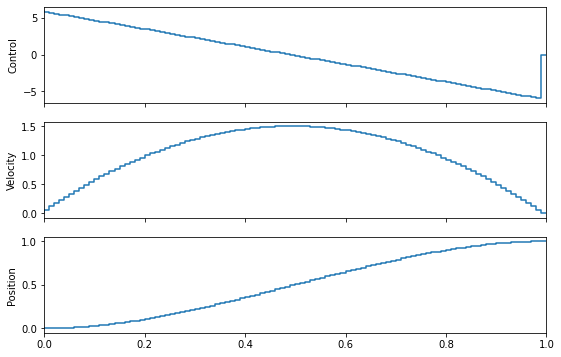

In [13]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(9, 6))

ax[0].step(Δt*steps, u_eopt)
ax[0].set(ylabel="Control")

ax[1].step(Δt*steps, x_eopt[:, 1])
ax[1].set(ylabel="Velocity")


ax[2].step(Δt*steps, x_eopt[:, 0])
ax[2].set(ylabel="Position", xlim=(0, τ))

Although the control achieves the desired goal, i.e. moving the mass from the rest position $x=0$ to $x=1$, the begining and the end of the ride might be unpleasant for passengers.
The acceleration (here directly $u$) initally goes from $u=0$ to $u \simeq 5$ over a small interval of time $\Delta t$.
Similarly, at the end of the ride, it goes from $u \simeq -5$ to $u=0$ over a the same time interval.
In the next exercise, we'll explore how to formulate an optimization problem to obtain a control sequence gradually increasing and decreasing over time.

## Exercise n°2: A smoother control

Rather than optimizing the energy efficiency of the control, we can optimize for its smoothness.
The resulting optimization problem can be formulated as

$$
\begin{aligned}
    \textrm{maximize} \quad & \dfrac{1}{2} \| \mathbf{Du} \|_2 \\
    \textrm{subject to} \quad & \mathbf{Hu} = \mathbf{y}_N
\end{aligned}
$$

where $\| \mathbf{Du} \|$ is a measure of the smoothness of the control sequence $\mathbf{u}$.
You can safely assume that $u[k] = 0$ for $k < 0$ and $k \geq N$.

---

**Task : Optimizing for the smoothness** 

- How would you define the matrix $\mathbf{D}$ ? Justify your choice in a few words.
- Write down the analytic solution to this optimization problem.

---

You now need to implement your solution below.

In [14]:
# --> Definition of the D matrix.
D = D = np.eye(N+1, N, k=0) - np.eye(N+1, N, k=-1)

In [15]:
# --> Computation of the smooth-optimal solution
u_sopt = inv(D.T @ D) @ H.T @ inv( H @ inv(D.T @ D) @ H.T) @ y_end

In [16]:
# --> Simulate the evolution of the system given this control law.
_, x_sopt, u_sopt = simulate(u_sopt)

[Text(0, 0.5, 'Position'), (0.0, 1.0)]

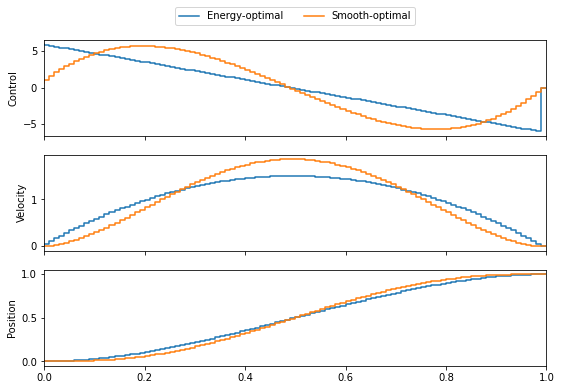

In [17]:
# --> Plot the evolution of the system.
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(9, 6))

ax[0].step(Δt*steps, u_eopt, label="Energy-optimal")
ax[0].step(Δt*steps, u_sopt, label="Smooth-optimal")
ax[0].set(ylabel="Control")
ax[0].legend(loc="lower center", bbox_to_anchor=(0.5, 1.1),ncol=2)

ax[1].step(Δt*steps, x_eopt[:, 1])
ax[1].step(Δt*steps, x_sopt[:, 1])
ax[1].set(ylabel="Velocity")


ax[2].step(Δt*steps, x_eopt[:, 0])
ax[2].step(Δt*steps, x_sopt[:, 0])
ax[2].set(ylabel="Position", xlim=(0, τ))

In [18]:
print("Energy ratio between the s-optimal and e-optimal control:", np.linalg.norm(u_sopt)**2 / np.linalg.norm(u_eopt)**2)

Energy ratio between the s-optimal and e-optimal control: 1.387778412335775


As expected, the control law now computed leads to a smoother ride than the energy-optimal one.
In particular, the acceleration gradually increases (resp. decreases) as the mobile starts (resp. stops) moving.
It thus no longer experiences jerk.
To achieve this goal, we however need 40% more energy than before.

## Exercise n°3: Balancing the two

Our goal is now to simultaneously optimize for the energy efficiency and smoothness of the control.
This is a multi-objective optimization problem which can be formulated as follows

$$
\begin{aligned}
    \textrm{maximize} \quad & \| \mathbf{Du} \|_2^2 + \lambda \| \mathbf{u} \|_2^2 \\
    \textrm{subject to} \quad & \mathbf{Hu} = \mathbf{y}_N,
\end{aligned}
$$

where $\lambda \in \mathbb{R}_+$ is a positive real number controlling the trade-off between the two objectives.

**Task : Multi-objective optimization**

- Write down the analytic solution to this optimization problem.   
- Implement a `python` function named `pareto_optimal` taking as input a particular value for $\lambda$ and returning the corresponding Pareto-optimal solution.

- Plot the graph $\| \mathbf{Du} \|$ vs. $\| \mathbf{u} \|$ as you vary $\lambda$ in the interval $\left[0, 1\right]$.

---

In [22]:
def pareto_optimal(λ):
    u = inv(D.T @ D + λ * np.eye(N)) @ H.T @ inv( H @ inv(D.T @ D + λ * np.eye(N)) @ H.T) @ y_end
    return u

In [23]:
# --> Possible values of λ
λs = np.logspace(-6, 1, 32)

# --> Compute all the solutions for the set of λs.
us = np.array([pareto_optimal(λ) for λ in λs]).T

# --> Compute the corresponding energy and "smoothness" of the control laws.
energy = np.linalg.norm(us, axis=0)
smoothness = np.linalg.norm( D @ us, axis=0)

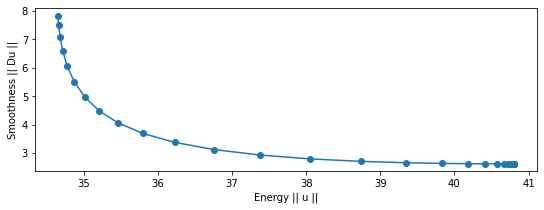

In [24]:
# --> Plot the pareto frontier.
fig, ax = plt.subplots(1, 1, figsize=(9, 3))

ax.plot(energy, smoothness, "-o")

ax.set(xlabel="Energy || u ||", ylabel="Smoothness || Du ||");

In [31]:
# --> Compute the solution that best balances the two objectives.
u_popt = pareto_optimal(0.05)
print("2-norm of the solution :", np.linalg.norm(u_popt))
print("S-norm of the solution :", np.linalg.norm(D @ u_popt))
print("Energy ratio between the p-optimal and e-optimal control:", np.linalg.norm(u_popt)**2 / np.linalg.norm(u_eopt)**2)
print("Smoothness ratio between the p-optimal and e-optimal control:", np.linalg.norm(D @ u_popt)**2 / np.linalg.norm(D @ u_eopt[:-1])**2)

_, x_popt, u_popt = simulate(u_popt)

2-norm of the solution : 36.31755012382812
S-norm of the solution : 3.3230060801506656
Energy ratio between the p-optimal and e-optimal control: 1.0990271254600565
Smoothness ratio between the p-optimal and e-optimal control: 0.15335090516357547


If you implemented correctly your solution, you should observe that the *Pareto-optimal* solution only requires 10% more energy than the energy-optimal one while being significantly smoother ($1/0.15 \simeq 6.6$ times smoother).
Let's now plot these solutions.

[Text(0, 0.5, 'Position'), (0.0, 1.0)]

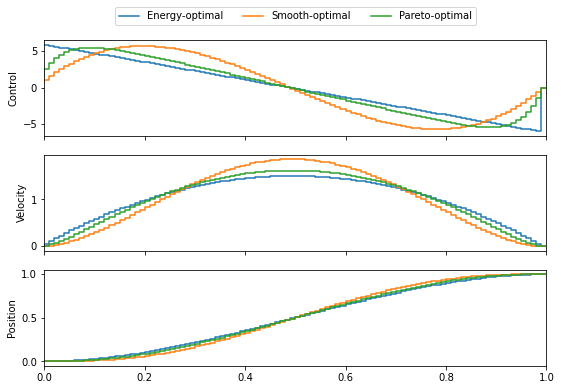

In [32]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(9, 6))

ax[0].step(Δt*steps, u_eopt, label="Energy-optimal")
ax[0].step(Δt*steps, u_sopt, label="Smooth-optimal")
ax[0].step(Δt*steps, u_popt, label="Pareto-optimal")
ax[0].set(ylabel="Control")
ax[0].legend(loc="lower center", bbox_to_anchor=(0.5, 1.1), ncol=3)

ax[1].step(Δt*steps, x_eopt[:, 1])
ax[1].step(Δt*steps, x_sopt[:, 1])
ax[1].step(Δt*steps, x_popt[:, 1])
ax[1].set(ylabel="Velocity")

ax[2].step(Δt*steps, x_eopt[:, 0])
ax[2].step(Δt*steps, x_sopt[:, 0])
ax[2].step(Δt*steps, x_popt[:, 0])
ax[2].set(ylabel="Position", xlim=(0, τ))

As you can see, the Pareto-optimal control law still increases (resp. decreases) gradually as the mobile starts (resp. stops) to move.
It does so however at a steeper rate.
During the rest of the ride, it follows relatively closely the energy-optimal solution.
Note that this is only one solution for a given value of $\lambda$.
Depending on your application, your passengers or device might accomodate for larger or smaller values of the jerk (i.e. the time-derivative of the acceleration).
You can do so in two different ways :
- Keep the current formulation of the problem and find the value of $\lambda$ such that your design constraints are satisfied,
- Hard code your constraints into the optimization problem directly. Doing so, you may no longer have an analytic solution and might have to use `cvxpy` if your problem nonetheless remains convex.

This is only a small example of what you do once you're comfortable with linear algebra and basic convex optimization theory.
While tackling problems with thousands or millions of optimization variables might be more challenging on the computing side (albeit there are some libraries dedicated to such large-scale optimization problems), the basic mathematics remain the same.
In some sense, the hardest part is to correctly formulate your problem.
Once this is done, simply use the right tool for it.

---

## To go further

Let's consider once again the smooth control and try to understand precisely why our particular choice of $\mathbf{D}$ leads to smooth solutions.
The optimization problem is given by

$$
\begin{aligned}
    \textrm{minimize} \quad & \dfrac{1}{2} \| \mathbf{Du} \|_2^2\\
    \textrm{subject to} \quad & \mathbf{Hu} = \mathbf{y}_N.
\end{aligned}
$$

Using the method of Lagrange multiplier, you should have arrived at the conclusion that the solution to this optimization problem is also the solution to the following linear system

$$
\mathbf{D}^T \mathbf{Du} = \mathbf{H}^T \left( \mathbf{H} \left( \mathbf{D}^T \mathbf{D} \right)^{-1} \mathbf{H}^T \right)^{-1} \mathbf{y}_N
$$

which we'll simply write as

$$
\mathbf{D}^T \mathbf{Du} = \mathbf{b}.
$$

Assume for the sake of simplicity that $N=5$ so that, for our particular choice of $\mathbf{D}$, the matrix $\mathbf{D}^T \mathbf{D}$ reads

$$
\mathbf{D}^T \mathbf{D}
=
\begin{bmatrix}
2 & -1 & 0 & 0 & 0 \\
-1 & 2 & -1 & 0 & 0 \\
0 & -1 & 2 & -1 & 0 \\
0 & 0 & -1 & 2 & -1 \\
0 & 0 & 0 & -1 & 2
\end{bmatrix}
$$

This particular matrix corresponds to the finite-difference approximation of the Laplace operator $-\nabla^2$.
This operator is what we call an [elliptic operator](https://en.wikipedia.org/wiki/Elliptic_operator).
Mathematically, equations involving such elliptic operators can only admit smooth solutions, hence our smooth control strategy.
In this particular case, we can moreover show that both the right and left eigenvectors of the Laplace operator are given by sine and cosine functions.

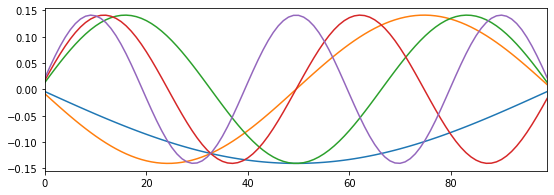

In [33]:
# --> Definition of the D matrix.
D = np.eye(N+1, N, k=0) - np.eye(N+1, N, k=-1)

# --> Define the Laplace operator.
L = D.T @ D

# --> Spectral decomposition of L.
λ, v = np.linalg.eig(L)

# --> Sort the eigenvalues in increasing order.
idx = np.argsort(λ.real)
λ, v = λ[idx], v[:, idx]

# --> Plot the first five eigenvectors.
fig, ax = plt.subplots(1, 1, figsize=(9, 3))

ax.plot(v[:, :5])
ax.set(xlim=(0, N-1));

Since


$$
\mathbf{D}^T \mathbf{Du} = \mathbf{b},
$$

and $\mathbf{D}^T \mathbf{D}$ is invertible, $\mathbf{u}$ needs to be in the span of these eigenfunctions, i.e. it needs to be a linear combination of sines and cosines.
These functions being smooth and satisfying the boundary conditions $f(-1) = 0$ and $f(N) = 0$, the optimal control law $\mathbf{u}_{\text{sopt}}$ is automatically smooth and satisifies the same boundary conditions.

QED.

---

The same reasonning applies to the case where we try to balance the smoothness of the control and its energy-efficiency.
The linear system resulting from the optimiality conditions reads

$$
\left( \mathbf{D}^T \mathbf{D} + \lambda \mathbf{I} \right) \mathbf{u} = \mathbf{b}.
$$

The matrix $\mathbf{D}^T \mathbf{D} + \lambda \mathbf{I}$ corresponds to the finite-difference approximation of the **Helmholtz operator** $\lambda - \nabla^2$.
This operator is once again **elliptic** and the solutions thus have to be smooth.
The parameter $\lambda \in \mathbb{R}_+$ then controls the smoothness of the solutions in what are known as boundary layers in the vicinity of $k=0$ and $k=N$.
As $\lambda \to 0$, the solution tends to the solution of the Laplace operator.
Conversely, as $\lambda \to \infty$, the solution exhibits sharper and sharper transitions at the boundaries of our time interval.